In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

matches_df = pd.read_csv('matches.csv');
deliveries_df = pd.read_csv('deliveries.csv');

print('Matches Data Dimensions: ', matches_df.shape)
print (matches_df.columns)
print('Deliveries Data Dimensions: ', deliveries_df.shape)
print (deliveries_df.columns)

Matches Data Dimensions:  (756, 18)
Index(['id', 'season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'umpire3'],
      dtype='object')
Deliveries Data Dimensions:  (179078, 21)
Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')


In [2]:
print ("==================== NULLS in DELIVERIES ====================")
print (deliveries_df.isnull().sum())
print ("==================== NULLS in MATCHES ====================")
print (matches_df.isnull().sum())

==================== NULLS in DELIVERIES ====================
match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
is_super_over            0
wide_runs                0
bye_runs                 0
legbye_runs              0
noball_runs              0
penalty_runs             0
batsman_runs             0
extra_runs               0
total_runs               0
player_dismissed    170244
dismissal_kind      170244
fielder             172630
dtype: int64
==================== NULLS in MATCHES ====================
id                   0
season               0
city                 7
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               4
win_by_runs          0
win_by_wickets       0


In [3]:
matches_drop_cols = ['date','umpire3']
deliveries_drop_cols = ['player_dismissed']
matches_df = matches_df.drop(matches_drop_cols, axis=1)
deliveries_df = deliveries_df.drop(deliveries_drop_cols, axis=1)

In [4]:
combined_df = pd.merge(matches_df, deliveries_df, left_on='id', right_on='match_id')
print (combined_df.columns)

Index(['id', 'season', 'city', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'dismissal_kind',
       'fielder'],
      dtype='object')


In [5]:
combined_df['team1'].replace({'Rising Pune Supergiant' : 'Rising Pune Supergiants'}, inplace=True)
combined_df['team2'].replace({'Rising Pune Supergiant' : 'Rising Pune Supergiants'}, inplace=True)
combined_df['winner'].replace({'Rising Pune Supergiant' : 'Rising Pune Supergiants'}, inplace=True)
combined_df['toss_winner'].replace({'Rising Pune Supergiant' : 'Rising Pune Supergiants'}, inplace=True)
combined_df['batting_team'].replace({'Rising Pune Supergiant' : 'Rising Pune Supergiants'}, inplace=True)
combined_df['bowling_team'].replace({'Rising Pune Supergiant' : 'Rising Pune Supergiants'}, inplace=True)


combined_df['venue'].replace({'Punjab Cricket Association IS Bindra Stadium, Mohali' : 'Punjab Cricket Association Stadium, Mohali'}, inplace=True)

combined_df['is_winner'] = np.where(combined_df['batting_team'] == combined_df['winner'], 'yes', 'no')

# Delete matches data which are incomplete
ids_of_matches_with_no_decision = matches_df[matches_df['winner'].isnull()]['id'].unique()
combined_df = combined_df[~combined_df['match_id'].isin(ids_of_matches_with_no_decision)]

   Innings Winner  Count of Matches
0        1     no               417
1        1    yes               335
2        2     no               335
3        2    yes               417
4        3     no                 4
5        3    yes                 5
6        4     no                 4
7        4    yes                 3
8        5     no                 1
9        5    yes                 1


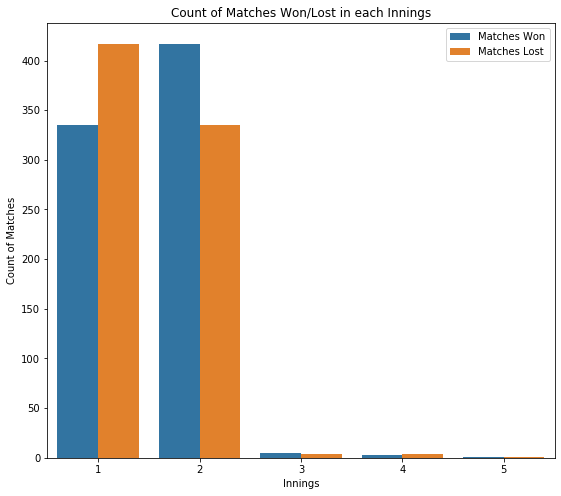

In [6]:
match_won_in_each_innings = combined_df.loc[: , ['match_id', 'inning', 'is_winner']].drop_duplicates()
print (match_won_in_each_innings.groupby(['inning', 'is_winner'])['match_id'].count().reset_index().rename(columns={'inning' : 'Innings' , 'is_winner' : 'Winner', 'match_id' : 'Count of Matches'}))

plt.figure(figsize=(20, 8))

ax0 = plt.subplot(121)
g = sns.countplot(x='inning', hue='is_winner', data=match_won_in_each_innings, ax=ax0)
g.set_xlabel('Innings')
g.set_ylabel('Count of Matches')
g.set_title('Count of Matches Won/Lost in each Innings')
plt.legend(['Matches Won', 'Matches Lost'])

In [7]:
teams_score_per_power_play = combined_df.loc[:, ['match_id', 'over', 'total_runs', 'is_winner', 'season']]
teams_score_per_power_play['power_play'] = np.where(teams_score_per_power_play['over'] <= 6, 'yes', 'no')
teams_score_per_power_play = teams_score_per_power_play.groupby(['season', 'match_id', 'is_winner', 'power_play'])['total_runs'].sum().reset_index(name ='score')
teams_score_per_power_play["avg_score_per_over"] = np.where(teams_score_per_power_play["power_play"] == 'yes', teams_score_per_power_play["score"].div(6, axis=0), teams_score_per_power_play["score"].div(14, axis=0))

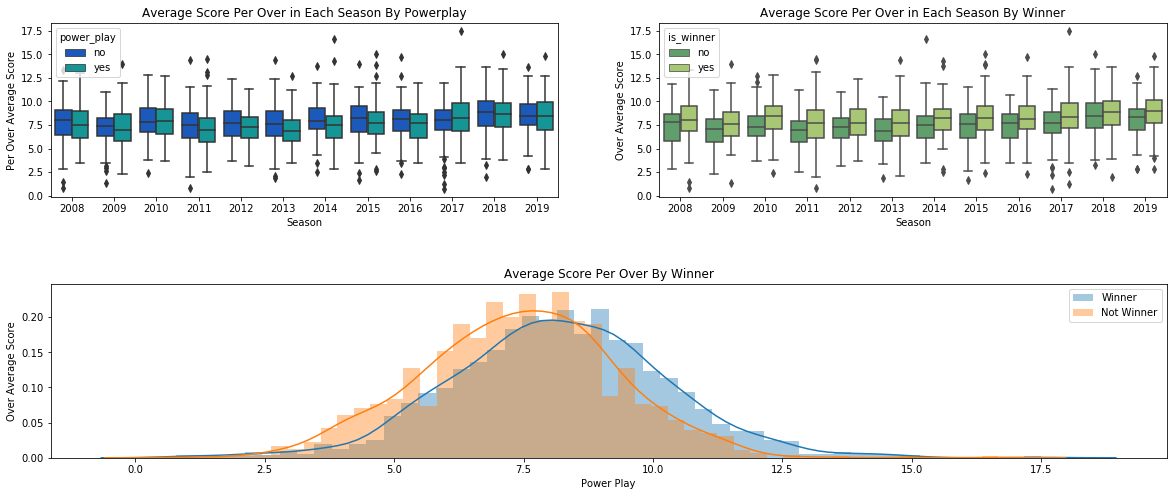

In [8]:
plt.figure(figsize=(20 , 8))

ax0 = plt.subplot(221)
sns.boxplot(x="season", y="avg_score_per_over", hue="power_play", data=teams_score_per_power_play, ax=ax0, palette='winter')
plt.xlabel('Season')
plt.ylabel('Per Over Average Score')
plt.title('Average Score Per Over in Each Season By Powerplay')

ax1 = plt.subplot(222)
sns.boxplot(x="season", y="avg_score_per_over", hue="is_winner", data=teams_score_per_power_play, ax=ax1, palette='summer')
plt.xlabel('Season')
plt.ylabel('Over Average Score')
plt.title('Average Score Per Over in Each Season By Winner')

ax2 = plt.subplot(212)
# sns.boxplot(x="power_play", y="avg_score_per_over", hue="is_winner", data=teams_score_per_power_play, ax=ax2, palette='Set1')
sns.distplot(teams_score_per_power_play[teams_score_per_power_play['is_winner'] == 'yes']['avg_score_per_over'], bins=50, ax=ax2, label='Winner')
sns.distplot(teams_score_per_power_play[teams_score_per_power_play['is_winner'] == 'no']['avg_score_per_over'], bins=50, ax=ax2, label='Not Winner')
plt.legend()
plt.xlabel('Power Play')
plt.ylabel('Over Average Score')
plt.title('Average Score Per Over By Winner')

plt.subplots_adjust(hspace=0.5)

,winning_team_won_toss,Toss Decision,Count of Matches
0,no,bat,158
1,no,field,201
2,yes,bat,134
3,yes,field,259


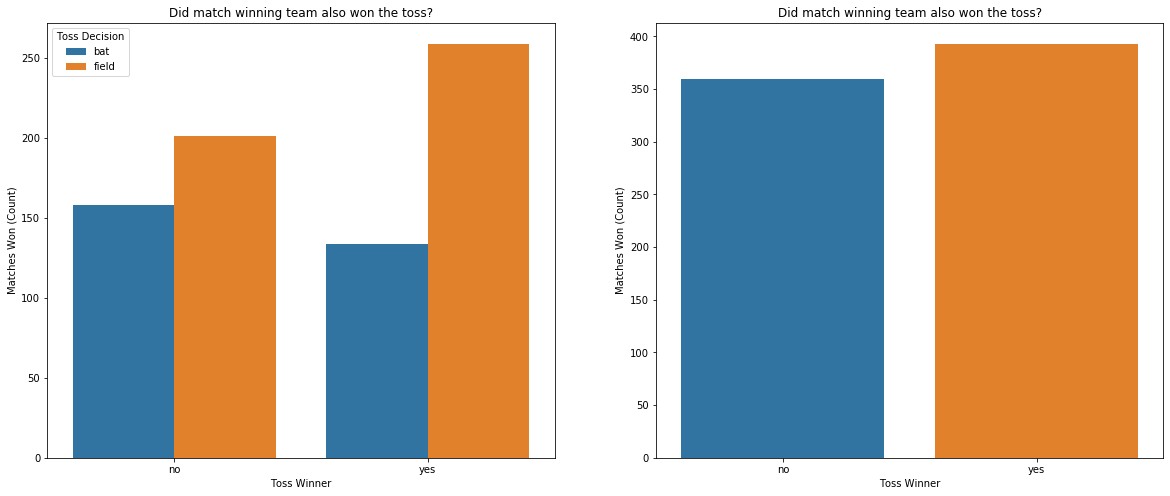

In [9]:
winner_team_score_each_season = combined_df.loc[:, ['match_id', 'toss_winner', 'toss_decision', 'winner']].drop_duplicates()
winner_team_score_each_season['winning_team_won_toss'] = np.where(winner_team_score_each_season['toss_winner'] == winner_team_score_each_season['winner'], 'yes', 'no')
winner_team_score_each_season = winner_team_score_each_season.groupby(['winning_team_won_toss', 'toss_decision'])['match_id'].count().reset_index().rename(columns={"match_id" : 'Count of Matches', 'toss_decision' : 'Toss Decision'})

plt.figure(figsize=(20, 8))

ax0 = plt.subplot(121)
sns.barplot(x="winning_team_won_toss", y="Count of Matches", hue="Toss Decision", data=winner_team_score_each_season, ax=ax0);
ax0.set_xlabel('Toss Winner')
ax0.set_ylabel('Matches Won (Count)')
ax0.set_title('Did match winning team also won the toss?')

ax1 = plt.subplot(122)
sns.barplot(x = 'winning_team_won_toss', y='Count of Matches', data=winner_team_score_each_season.groupby(['winning_team_won_toss'])['Count of Matches'].sum().reset_index(), ax=ax1)
ax1.set_xlabel('Toss Winner')
ax1.set_ylabel('Matches Won (Count)')
ax1.set_title('Did match winning team also won the toss?')

winner_team_score_each_season

Text(0.5, 0, 'Batting Team')

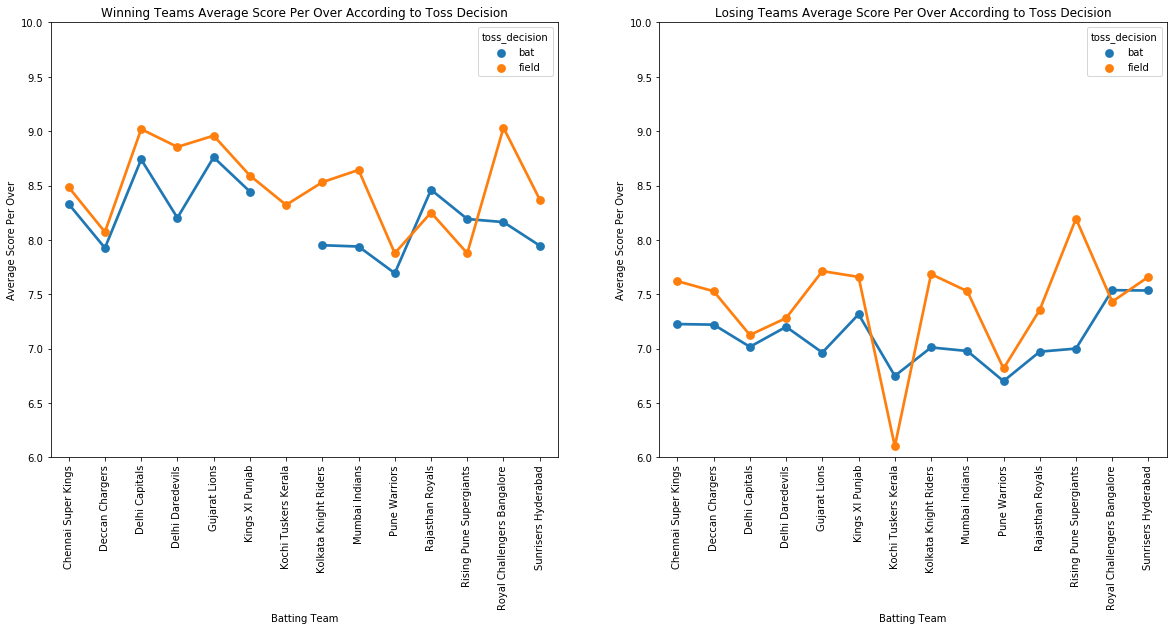

In [10]:
# Lets check average per over score of winning teams
total_scores_and_balls_winner = combined_df[combined_df['batting_team'] == combined_df['winner']].groupby(['batting_team', 'toss_decision'])['total_runs'].agg(['count', 'sum']).reset_index().rename(columns={'count' : 'balls_count', 'sum' : 'match_score'})
total_scores_and_balls_winner['overs_count'] = np.divide(total_scores_and_balls_winner['balls_count'], 6.0)
total_scores_and_balls_winner['average_score_per_over'] = np.divide(total_scores_and_balls_winner['match_score'], total_scores_and_balls_winner['overs_count'])
total_scores_and_balls_winner[['batting_team', 'toss_decision', 'average_score_per_over']]

plt.figure(figsize=(20,8))

ax0 = plt.subplot(121)
g = sns.pointplot(x='batting_team', y='average_score_per_over', hue='toss_decision', data=total_scores_and_balls_winner, ax=ax0)
plt.ylim(6, 10)
plt.xticks(rotation=90)
plt.title('Winning Teams Average Score Per Over According to Toss Decision')
plt.ylabel('Average Score Per Over')
plt.xlabel('Batting Team')

total_scores_and_balls_winner = combined_df[combined_df['batting_team'] != combined_df['winner']].groupby(['batting_team', 'toss_decision'])['total_runs'].agg(['count', 'sum']).reset_index().rename(columns={'count' : 'balls_count', 'sum' : 'match_score'})
total_scores_and_balls_winner['overs_count'] = np.divide(total_scores_and_balls_winner['balls_count'], 6.0)
total_scores_and_balls_winner['average_score_per_over'] = np.divide(total_scores_and_balls_winner['match_score'], total_scores_and_balls_winner['overs_count'])
total_scores_and_balls_winner[['batting_team', 'toss_decision', 'average_score_per_over']]

ax1 = plt.subplot(122)
g = sns.pointplot(x='batting_team', y='average_score_per_over', hue='toss_decision', data=total_scores_and_balls_winner, ax=ax1, sharey=ax0)
plt.ylim(6, 10)
plt.xticks(rotation=90)
plt.title('Losing Teams Average Score Per Over According to Toss Decision')
plt.ylabel('Average Score Per Over')
plt.xlabel('Batting Team')


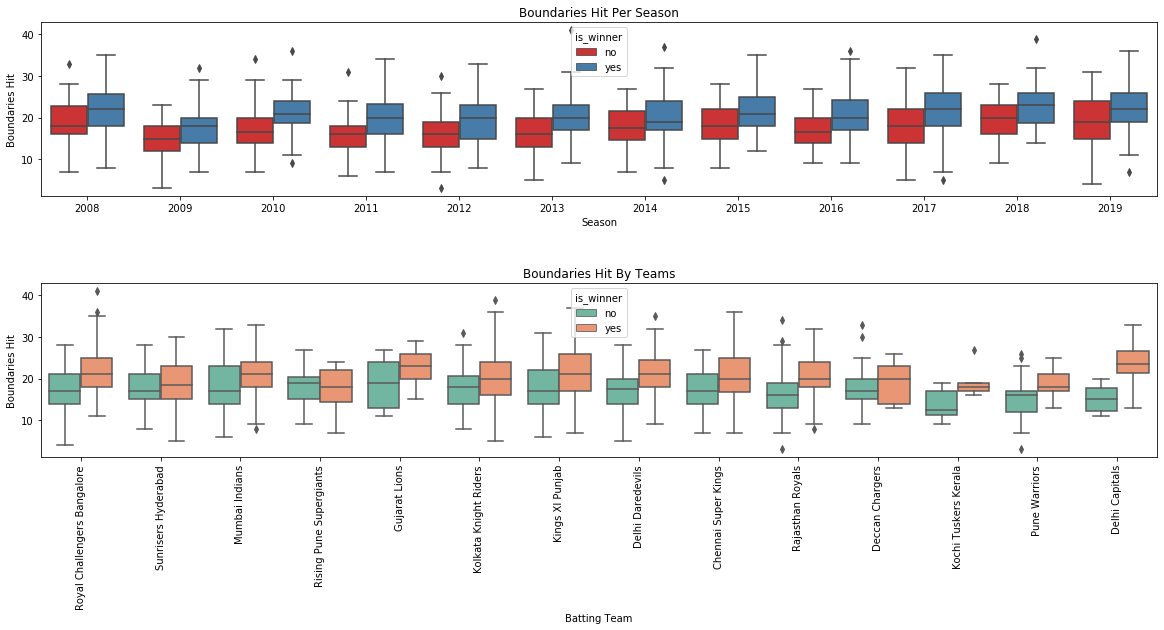

In [11]:
total_4s6s_per_team_per_match = combined_df.loc[:, ['season', 'total_runs', 'match_id', 'is_winner']]
boundaries_per_season = total_4s6s_per_team_per_match.groupby(['season', 'match_id', 'is_winner'])['total_runs'].agg(lambda runs: ((runs == 4) | (runs == 6)).sum()).reset_index()
boundaries = boundaries_per_season.rename(columns={'total_runs':'boundaries'})

plt.figure(figsize=(20,8))
ax0 = plt.subplot(211)
g = sns.boxplot(x='season', y= 'boundaries', hue='is_winner' ,data=boundaries, palette='Set1', ax=ax0)
g.set_xlabel('Season')
g.set_ylabel('Boundaries Hit')
g.set_title('Boundaries Hit Per Season')

total_4s6s_per_team_per_match = combined_df.loc[:, ['match_id', 'batting_team', 'total_runs', 'is_winner']]
boundaries_per_season = total_4s6s_per_team_per_match.groupby(['match_id', 'batting_team' , 'is_winner'])['total_runs'].agg(lambda runs: ((runs == 4) | (runs == 6)).sum()).reset_index()
boundaries = boundaries_per_season.rename(columns={'total_runs':'boundaries'})

ax1 = plt.subplot(212)
g = sns.boxplot(x='batting_team', y= 'boundaries', hue='is_winner' ,data=boundaries, palette='Set2', ax=ax1)
g.set_xlabel('Batting Team')
g.set_ylabel('Boundaries Hit')
g.set_title('Boundaries Hit By Teams')
plt.xticks(rotation=90)

plt.subplots_adjust(hspace=0.5)

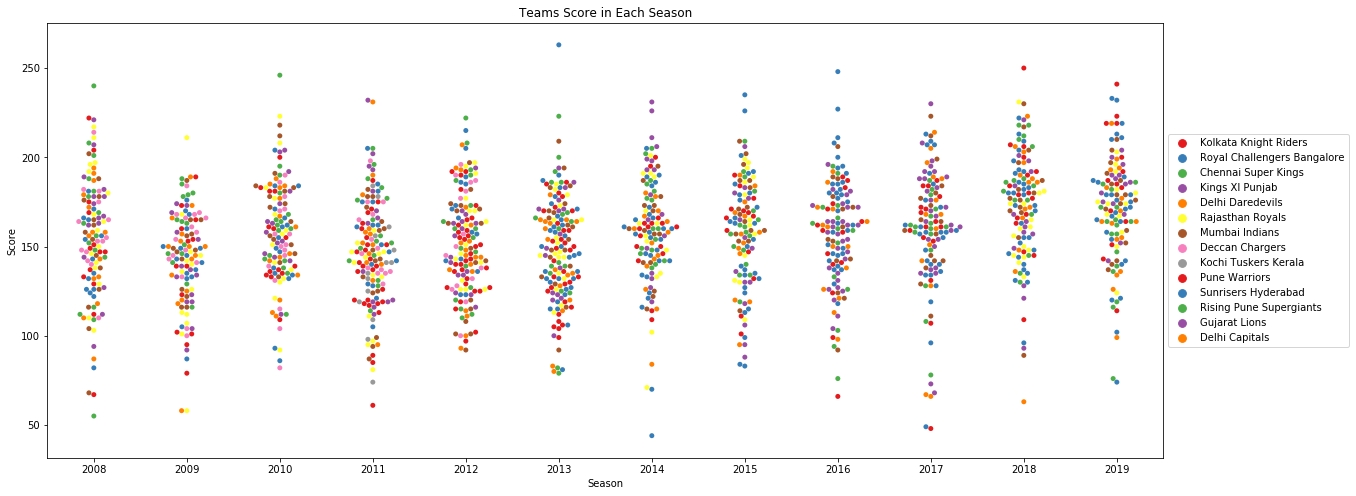

In [12]:
teams_score_per_season = combined_df.loc[: , ['season', 'match_id', 'batting_team', 'total_runs']]
teams_score_per_season = teams_score_per_season.groupby(['season', 'match_id', 'batting_team'])['total_runs'].agg(np.sum).reset_index()
#teams_score_per_season

plt.figure(figsize=(20, 8))
ax0 = plt.subplot(111)
g = sns.swarmplot(x='season', y='total_runs', hue='batting_team', data=teams_score_per_season, ax=ax0, palette='Set1')
g.set_title('Teams Score in Each Season')
g.set_xlabel('Season')
g.set_ylabel('Score')
ax0.legend(loc='center left', bbox_to_anchor=(1, 0.5))

,batsman,total_runs,balls_count,strike_rate
428,SK Raina,5651,4044,139.737883
486,V Kohli,5589,4198,133.134826
367,RG Sharma,5057,3816,132.520964
112,DA Warner,4954,3388,146.221960
392,S Dhawan,4876,3776,129.131356
92,CH Gayle,4862,3122,155.733504
384,RV Uthappa,4703,3492,134.679267
290,MS Dhoni,4691,3318,141.380350
26,AB de Villiers,4507,2926,154.032809
147,G Gambhir,4485,3524,127.270148


<Figure size 1440x576 with 0 Axes>

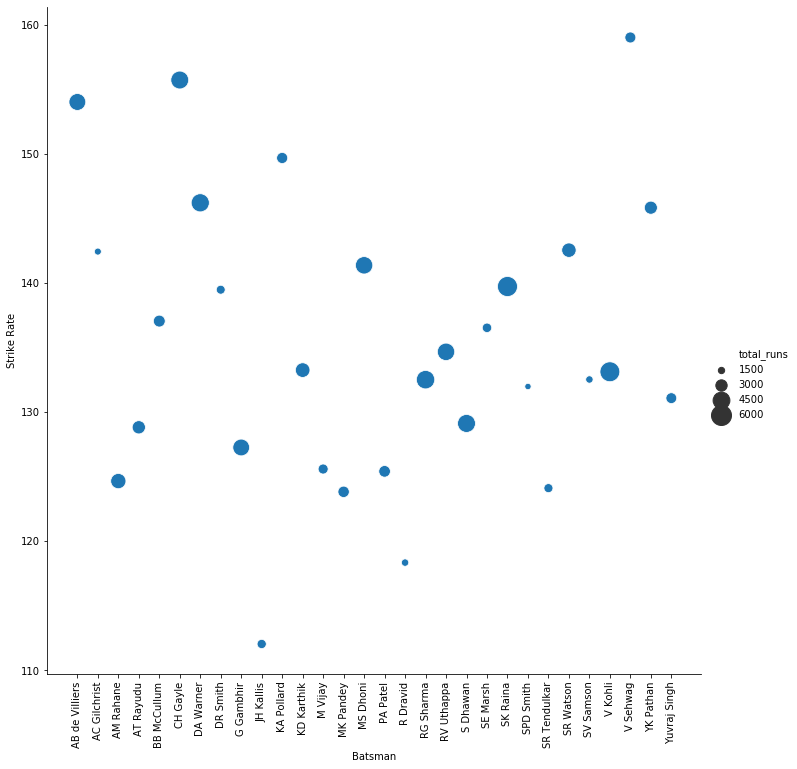

In [13]:
batsman_score = combined_df.loc[:, ['batsman', 'total_runs']]
batsman_score = batsman_score.groupby(['batsman'])['total_runs'].agg(['sum', 'count']).reset_index().rename(columns={'sum' : 'total_runs' , 'count' : 'balls_count'})
batsman_score['strike_rate'] = np.divide(batsman_score['total_runs'], batsman_score['balls_count']) * 100

plt.figure(figsize=(20, 8))
g = sns.relplot(x="batsman", y="strike_rate", size="total_runs",sizes=(40, 400), palette="muted", height=10, data=batsman_score.nlargest(30, ['total_runs']).sort_values(['batsman']))
plt.xlabel('Batsman')
plt.ylabel('Strike Rate')
plt.xticks(rotation=90)

batsman_score.nlargest(30, ['total_runs'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

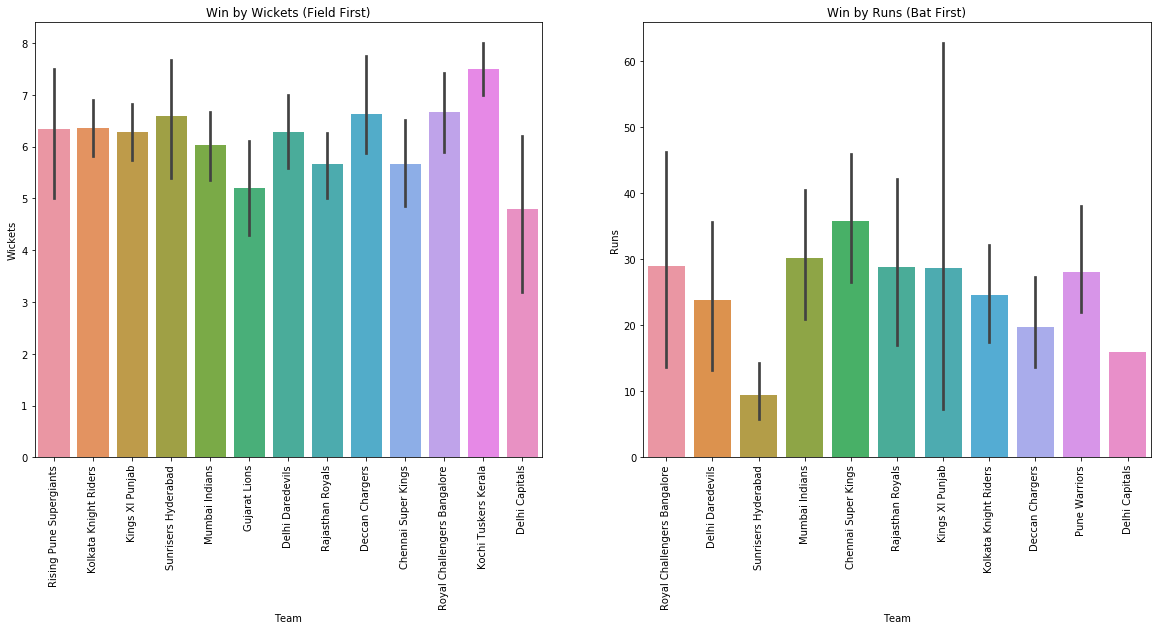

In [14]:
win_by = combined_df.loc[:, ['id', 'toss_winner','toss_decision', 'win_by_wickets', 'win_by_runs']]
win_by_wickets = win_by[(win_by['toss_decision'] == 'field') & (win_by['win_by_wickets'] != 0)].loc[:, ['id', 'toss_winner', 'win_by_wickets']].drop_duplicates()
plt.figure(figsize=(20, 8))

ax0 = plt.subplot(121)
g = sns.barplot(data=win_by_wickets, x='toss_winner', y='win_by_wickets', ax=ax0)
g.set_xlabel('Team')
g.set_ylabel('Wickets')
g.set_title('Win by Wickets (Field First)')
plt.xticks(rotation=90)

win_by_runs = win_by[(win_by['toss_decision'] == 'bat') & (win_by['win_by_runs'] != 0)].loc[:, ['id', 'toss_winner', 'win_by_runs']].drop_duplicates()
ax0 = plt.subplot(122)
g = sns.barplot(data=win_by_runs, x='toss_winner', y='win_by_runs', ax=ax0)
g.set_xlabel('Team')
g.set_ylabel('Runs')
g.set_title('Win by Runs (Bat First)')
plt.xticks(rotation=90)


In [15]:
top_man_of_matches = combined_df.loc[:, ['match_id', 'player_of_match']].drop_duplicates()
top_man_of_matches = top_man_of_matches.groupby(['player_of_match'])['match_id'].count().nlargest(5).reset_index().rename(columns={'match_id' : 'total_matches'})
top_man_of_matches

,player_of_match,total_matches
0,CH Gayle,21
1,AB de Villiers,20
2,DA Warner,17
3,MS Dhoni,17
4,RG Sharma,17


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 <a list of 40 Text xticklabel objects>)

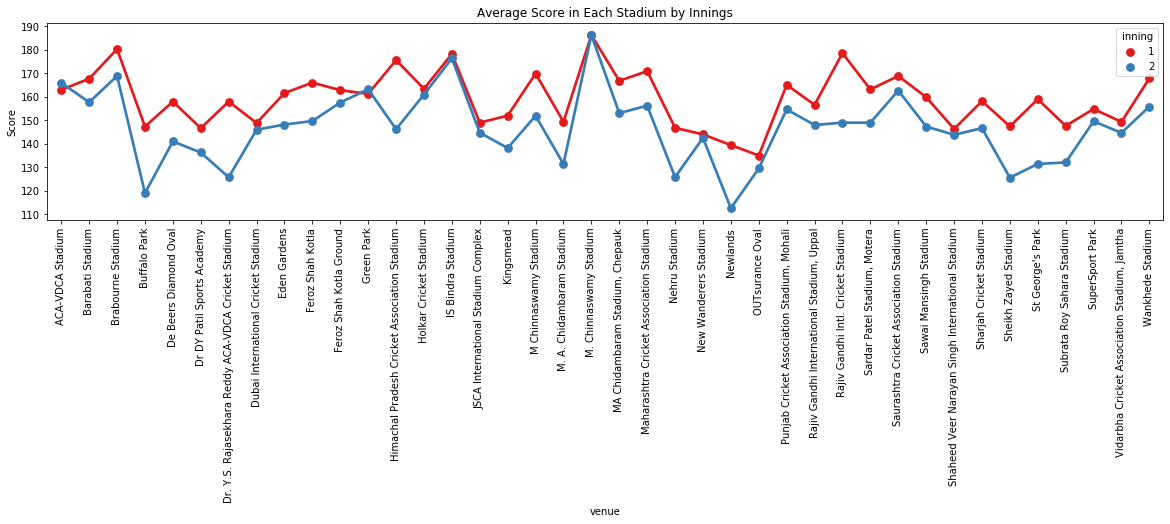

In [16]:
score_per_venue = combined_df.loc[:, ['match_id', 'venue', 'inning', 'total_runs']]
average_score_per_venue = score_per_venue.groupby(['match_id', 'venue', 'inning']).agg({'total_runs' : 'sum'}).reset_index()
average_score_per_venue = average_score_per_venue.groupby(['venue', 'inning'])['total_runs'].mean().reset_index()
average_score_per_venue = average_score_per_venue[(average_score_per_venue['inning'] == 1) | (average_score_per_venue['inning'] == 2)]

plt.figure(figsize=(20, 8))

ax2 = plt.subplot(211)
g = sns.pointplot(x='venue', y='total_runs', hue='inning', data=average_score_per_venue, ax=ax2, palette='Set1')
g.set_ylabel('Score')
g.set_title('Average Score in Each Stadium by Innings')
plt.xticks(rotation=90)

,index,venue,bat,field
0,0,ACA-VDCA Stadium,0.0,2.0
1,1,Barabati Stadium,2.0,5.0
2,2,Brabourne Stadium,6.0,5.0
3,3,Buffalo Park,3.0,0.0
4,4,De Beers Diamond Oval,2.0,1.0
5,5,Dr DY Patil Sports Academy,7.0,10.0
6,6,Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket St...,5.0,6.0
7,7,Dubai International Cricket Stadium,3.0,4.0
8,8,Eden Gardens,28.0,49.0
9,9,Feroz Shah Kotla,27.0,39.0


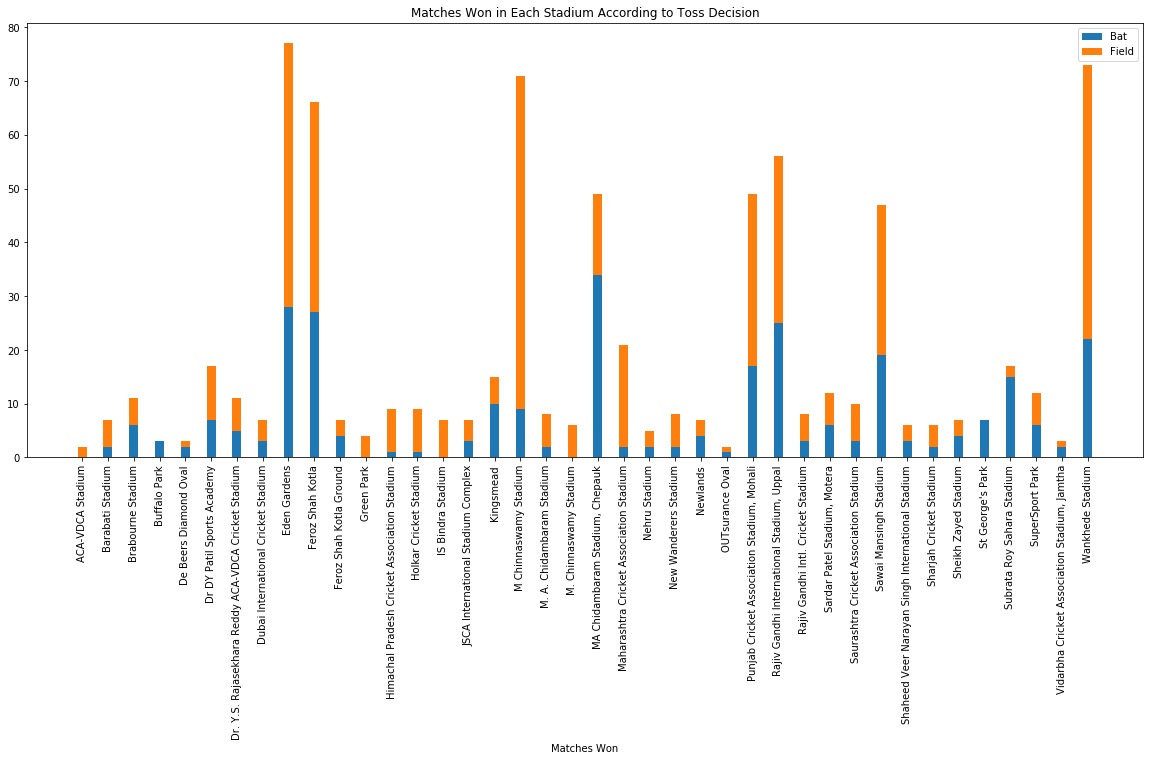

In [17]:
toss_vs_venue = combined_df.loc[:, ['match_id', 'venue', 'toss_decision', 'toss_winner', 'winner']].drop_duplicates()
toss_vs_venue['is_winner'] = np.where(toss_vs_venue['toss_winner'] == toss_vs_venue['winner'], 'yes', 'no')
toss_vs_venue.drop(['toss_winner', 'winner'], axis=1, inplace=True)
toss_vs_venue = toss_vs_venue.groupby(['venue', 'toss_decision'])['is_winner'].count().reset_index().rename(columns={'is_winner' : 'matches_won'})
toss_vs_venue = pd.DataFrame(toss_vs_venue.pivot_table('matches_won', ['venue'], 'toss_decision').reset_index().to_records())
toss_vs_venue = toss_vs_venue.fillna(0)

plt.figure(figsize=(20, 8))
p1 = plt.bar(toss_vs_venue['index'], toss_vs_venue['bat'], width=0.35)
p2 = plt.bar(toss_vs_venue['index'], toss_vs_venue['field'], width=0.35, bottom=toss_vs_venue['bat'])
plt.xticks(toss_vs_venue['index'], toss_vs_venue['venue'], rotation=90)
plt.legend((p1[0], p2[0]), ('Bat', 'Field'))
plt.xlabel('Matches Won')
plt.title('Matches Won in Each Stadium According to Toss Decision')

toss_vs_venue

Text(0.5, 1.0, 'Winning Team (Orange) vs Losing Team (Blue) Percentage of Boundaries per Match')

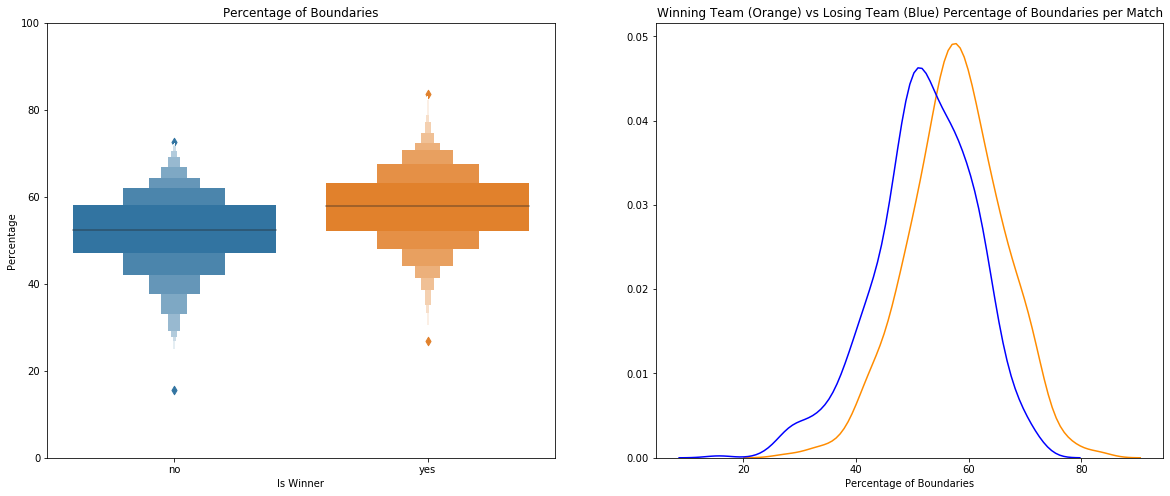

In [18]:
def findPercentScoreOfBoundaries(ser):
    boundaries_score = 0
    total_score = 0
    for runs in ser:
        if ((runs == 4) | (runs == 6)):
            boundaries_score += runs
        total_score += runs
    return (boundaries_score / total_score) * 100
 
winning_team_percent_boundaries = total_4s6s_per_team_per_match.groupby(['match_id', 'is_winner'])['total_runs'].apply(findPercentScoreOfBoundaries).reset_index().rename(columns={'total_runs' : 'percentage_of_boundaries'})

plt.figure(figsize=(20, 8))

ax0 = plt.subplot(121)
g = sns.boxenplot(x='is_winner', y='percentage_of_boundaries', data=winning_team_percent_boundaries, ax=ax0)
g.set_title('Percentage of Boundaries')
g.set_ylabel('Percentage')
g.set_xlabel('Is Winner')
g.set_ylim(0, 100)

ax1 = plt.subplot(122)
g = sns.distplot(winning_team_percent_boundaries[winning_team_percent_boundaries['is_winner'] == 'yes']['percentage_of_boundaries'], hist=False, ax=ax1, color='darkorange')
g = sns.distplot(winning_team_percent_boundaries[winning_team_percent_boundaries['is_winner'] == 'no']['percentage_of_boundaries'], hist=False, ax=ax1, color='blue')
g.set_xlabel('Percentage of Boundaries')
g.set_title('Winning Team (Orange) vs Losing Team (Blue) Percentage of Boundaries per Match')

Winning Team (Blue) vs Losing Team (Orange)


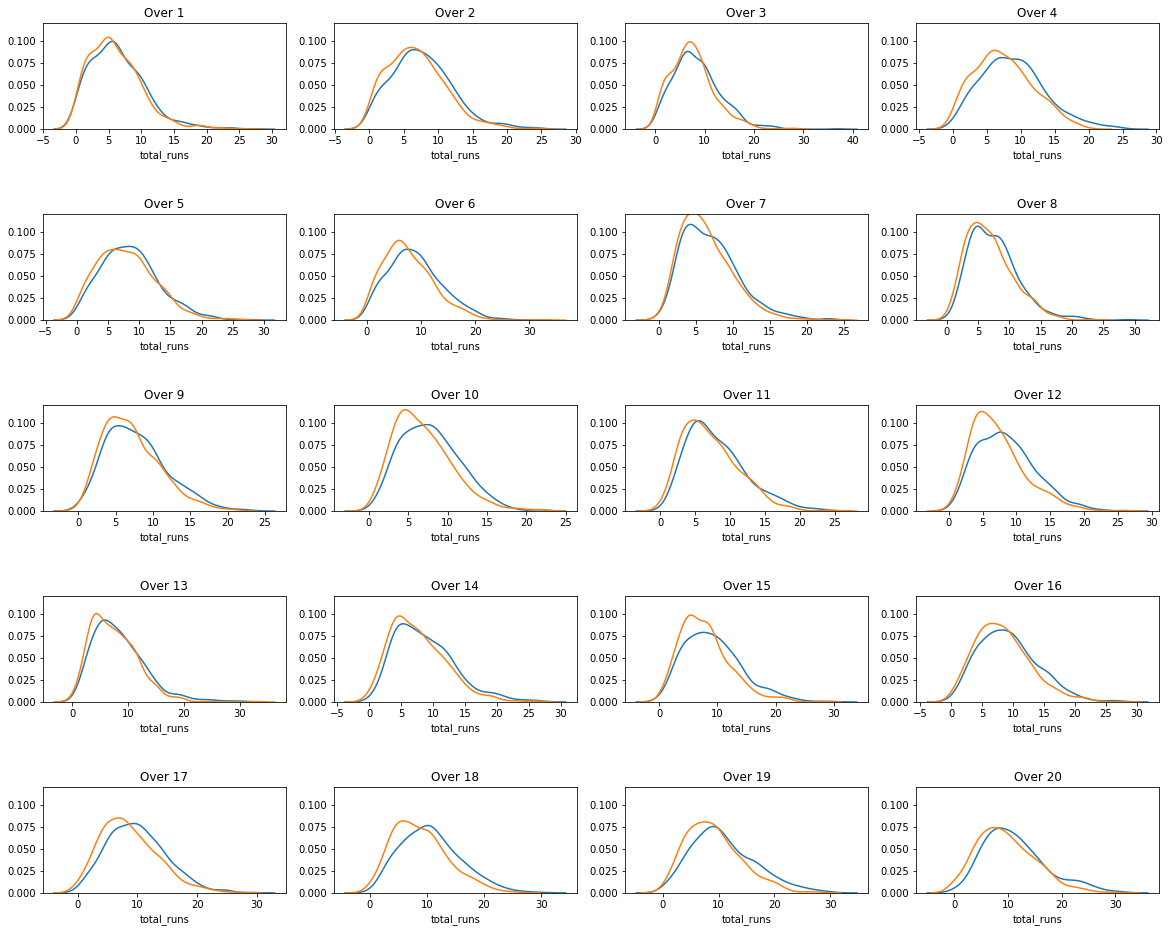

In [19]:
score_per_over_distribution = combined_df.loc[:, ['match_id', 'over', 'total_runs', 'batting_team', 'winner']]
score_per_over_distribution['is_winner'] = np.where(score_per_over_distribution['batting_team'] == score_per_over_distribution['winner'], 'yes', 'no')
score_per_over_distribution.drop(['batting_team', 'winner'], axis=1, inplace=True)
score_per_over_distribution = score_per_over_distribution.groupby(['match_id', 'over', 'is_winner'])['total_runs'].agg(np.sum).reset_index()
plt.figure(figsize=(20, 16))

over = 1
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        p1 = sns.distplot(score_per_over_distribution[(score_per_over_distribution['over'] == over) & (score_per_over_distribution['is_winner'] == 'yes')]['total_runs'], hist=False, ax=ax)
        p2 = sns.distplot(score_per_over_distribution[(score_per_over_distribution['over'] == over) & (score_per_over_distribution['is_winner'] == 'no')]['total_runs'], hist=False, ax=ax)
        p1.set_title("Over " + str(over))
        p1.set_ylim([0, 0.12])
        p2.set_ylim([0, 0.12])
        over = over + 1

plt.subplots_adjust(hspace=0.8)
print('Winning Team (Blue) vs Losing Team (Orange)')

Text(0.5, 1.0, 'Distribution of score per over')

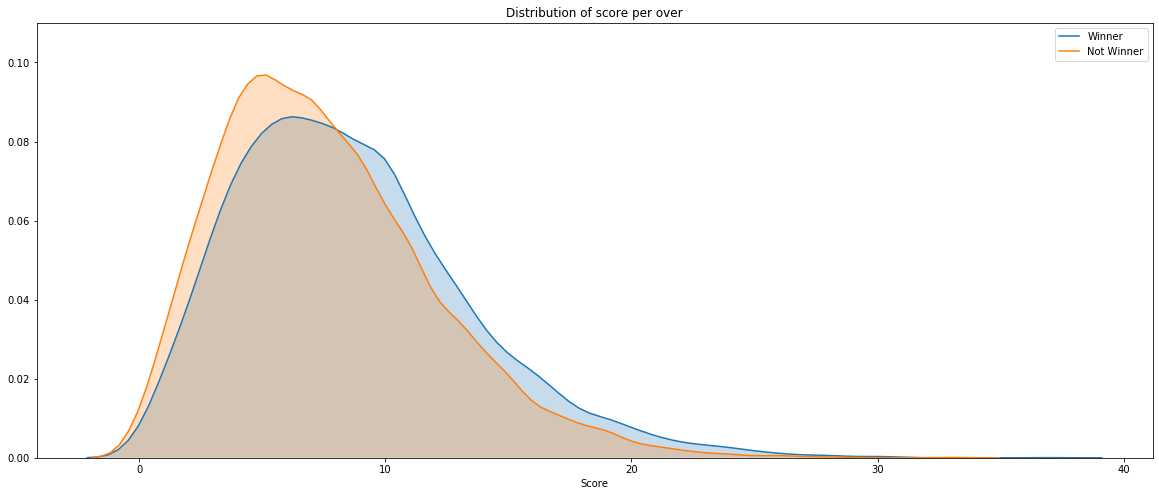

In [20]:
plt.figure(figsize=(20,8))
p1 = sns.kdeplot(score_per_over_distribution[score_per_over_distribution['is_winner'] == 'yes']['total_runs'], shade=True, legend=True)
p1.set_ylim([0, 0.11])
sns.kdeplot(score_per_over_distribution[score_per_over_distribution['is_winner'] == 'no']['total_runs'], shade=True, legend=True)
p2.set_ylim([0, 0.11])
plt.legend(['Winner', 'Not Winner'])
plt.xlabel('Score')
plt.title('Distribution of score per over')

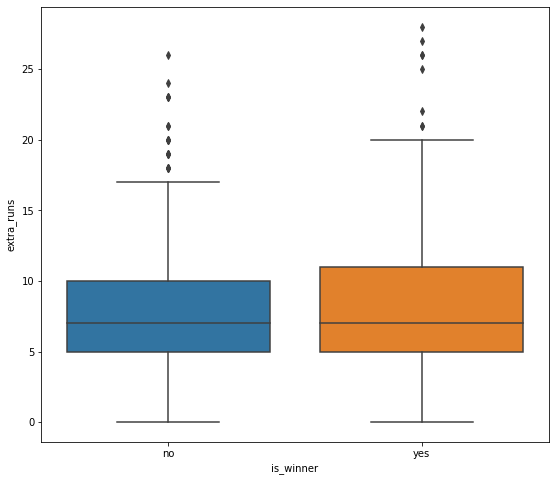

In [21]:
extra_runs = combined_df.loc[:, ['match_id', 'batting_team', 'winner', 'extra_runs']]
extra_runs['is_winner'] = np.where(extra_runs['batting_team'] == extra_runs['winner'], 'yes', 'no')
extra_runs.drop(['batting_team', 'winner'], axis=1, inplace=True)
extra_runs = extra_runs.groupby(['match_id', 'is_winner'])['extra_runs'].sum().reset_index()
#extra_runs
plt.figure(figsize=(20, 8))
ax0 = plt.subplot(121)
sns.boxplot(x='is_winner', y='extra_runs', data=extra_runs, ax=ax0)

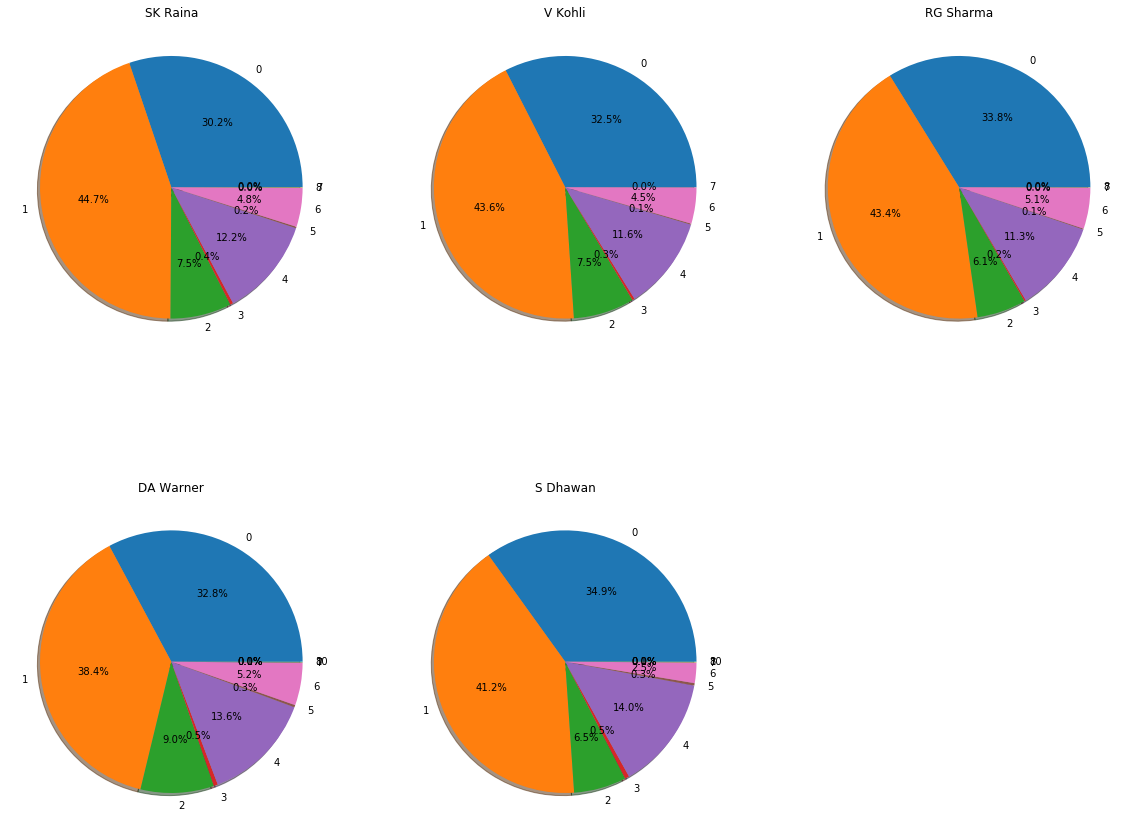

In [22]:
plt.figure(figsize=(20, 16))
plt.title('Breakdown of Top Batsmen Score')

top_scorer = batsman_score.nlargest(5, ['total_runs'])['batsman'].reset_index()
score_break_down = combined_df[combined_df['batsman'].isin(top_scorer['batsman'])].loc[:, ['id', 'batsman', 'total_runs']]
score_break_down = score_break_down.groupby(['batsman', 'total_runs'])['id'].count().reset_index().rename(columns={'id' : 'count'})

axes = [231, 232, 233, 234, 235]
index = 0
for batsman in top_scorer['batsman'].unique():
    subplt = plt.subplot(axes[index])
    subplt.set_title(batsman)
    index = index + 1
    subplt.pie(score_break_down[score_break_down['batsman'] == batsman]['count'], labels=score_break_down[score_break_down['batsman'] == batsman]['total_runs'], autopct='%1.1f%%', shadow=True)

In [23]:
pd.crosstab(combined_df.loc[:, ['match_id', 'winner']].drop_duplicates()['winner'], combined_df['season'], margins=True).style.background_gradient(cmap='summer_r')

season,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
winner,,,,,,,,,,,,,
Chennai Super Kings,9,8,9,11,10,12,10,10,0,0,11,10,100
Deccan Chargers,2,9,8,6,4,0,0,0,0,0,0,0,29
Delhi Capitals,0,0,0,0,0,0,0,0,0,0,0,10,10
Delhi Daredevils,7,10,7,4,11,3,2,5,7,6,5,0,67
Gujarat Lions,0,0,0,0,0,0,0,0,9,4,0,0,13
Kings XI Punjab,10,7,4,7,8,8,12,3,4,7,6,6,82
Kochi Tuskers Kerala,0,0,0,6,0,0,0,0,0,0,0,0,6
Kolkata Knight Riders,6,3,7,8,12,6,11,7,8,9,9,6,92
Mumbai Indians,7,5,11,10,10,13,7,10,7,12,6,11,109
